In [35]:
import matplotlib.pyplot as plt
import pandas as pd

#Loading our training data from csv
trainingData = pd.read_csv('trainingValues.csv')

print(trainingData.shape)

#Sorting by the feature id
trainingData = trainingData.sort_values("id")

#Dropping an insignificant column that contains approx 20k missing values
trainingData.drop("scheme_name",axis=1,inplace=True)

print(trainingData.shape)


(59400, 40)
(59400, 39)


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'amount_tsh'}>,
        <AxesSubplot:title={'center':'gps_height'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'num_private'}>],
       [<AxesSubplot:title={'center':'region_code'}>,
        <AxesSubplot:title={'center':'district_code'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'construction_year'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

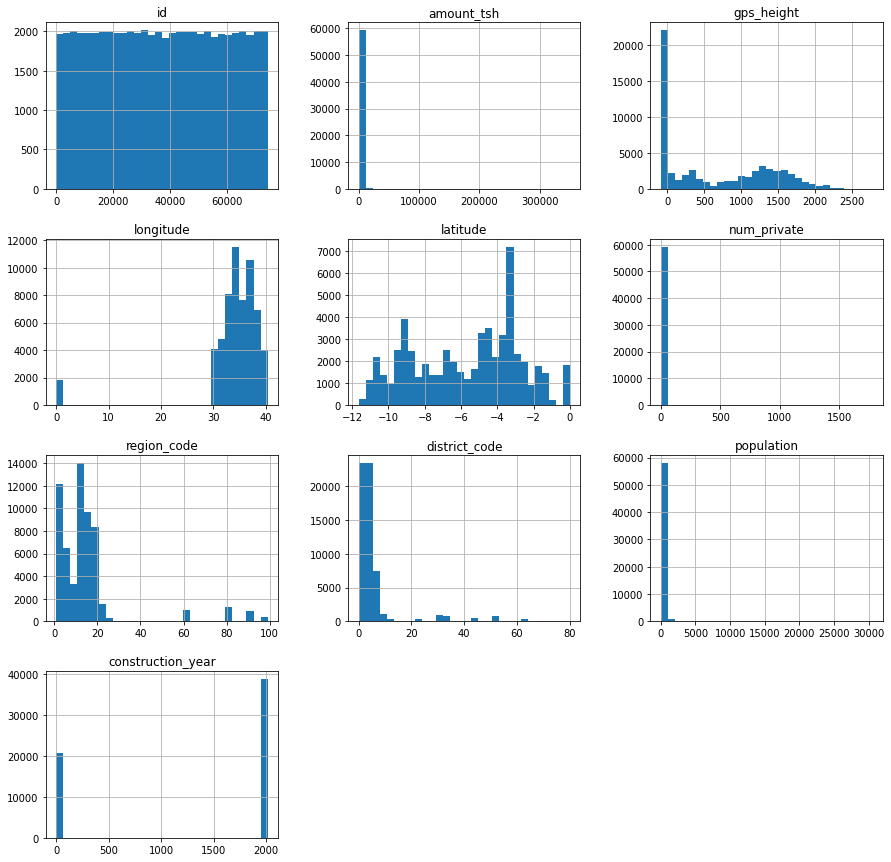

In [36]:
trainingData.hist(bins=30,figsize=(15,15),sharex=False)

### Histogram Comments
Of the numerical features only longitude and latitude appear to be evenly distributed. GPS height either contains lots of records where the feature has not been recorded or lots of records that are neither above or below sea level.

The majority of records are distributed in the lower regions and districts, however as we are not familiar with the geogrpahy of this country it is unknown why this may be the case. Perhaps the aras for which we do not have any records are well developed areas or areas not in need of water pumps.

Construction year appears to be either 2000 or missing, this will likely privide little in terms of importance to making predictions.

Population and amount_tsh are plagued by a significant number of missing values. We will use an imputer later on to fill in the missing values.

In [37]:
#REMOVE
from matplotlib import pyplot as plot
num_private = trainingData["num_private"]
num_private.value_counts()

0      58643
6         81
1         73
8         46
5         46
       ...  
755        1
672        1
698        1
23         1
94         1
Name: num_private, Length: 65, dtype: int64

In [38]:
#REMOVE
amount_tsh = trainingData["amount_tsh"]
amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
1400.0          1
200000.0        1
59.0            1
38000.0         1
170000.0        1
Name: amount_tsh, Length: 98, dtype: int64

# Visual Analysis

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

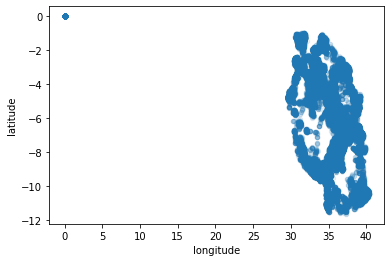

In [39]:
from matplotlib import pyplot as plt

trainingData.plot(x="longitude",
                  y="latitude",
                  kind="scatter",
                  alpha=0.1)

Plotting the longitude against the latitude gives us the general distribution of our water pumps in a form that approximately represents the shape of Tanzania. We now have a 'map' of all water pumps across Tanzania.

https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.123rf.com%2Fphoto_39230655_tanzania-country-flag-map-shape-national-symbol.html&psig=AOvVaw0MEKSedpQgGkjrWWKrcfhx&ust=1634549411520000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCIDa-5uR0fMCFQAAAAAdAAAAABAD

In the code snippet below we take the labels from our training data and perform a join on the training features dataframe. The result is a new dataframe that contains the location co-ordinates as well as the id (unique identifier used for the join) and the classification label of the water pump i.e. the value that we are trying to predict.

Lets overlay this classification on the plot above to see how water pumps are distributed geographically according to their functional status.


In [40]:
#Loading our training labels
trainingLabels = pd.read_csv('trainingLabels.csv')
trainingLabels = trainingLabels.sort_values("id")
#Joining with our training data to add in the long/lat, joining based on the ID

#Subsetting the data to create a smaller data frame that contains only the location data and the ID
coordinates = trainingData.loc[:,["id", "longitude","latitude"]]
coordinates = pd.merge(coordinates, trainingLabels, how="left", on="id")
print(coordinates.head())

   id  longitude  latitude    status_group
0   0  33.125828 -5.118154  non functional
1   1  34.770717 -9.395642      functional
2   2  36.115056 -6.279268      functional
3   3  37.147432 -3.187555      functional
4   4  36.164893 -6.099289  non functional


## Geographic Distribution of pumps according to functional status

In the scatter plot below the water pumps are represented as follows

Green dots - Functional Pumps
Yellow dots - Functional but in need of repair
Red dots - Not functional

   id  longitude  latitude    status_group colour
0   0  33.125828 -5.118154  non functional    red
1   1  34.770717 -9.395642      functional  green
2   2  36.115056 -6.279268      functional  green
3   3  37.147432 -3.187555      functional  green
4   4  36.164893 -6.099289  non functional    red


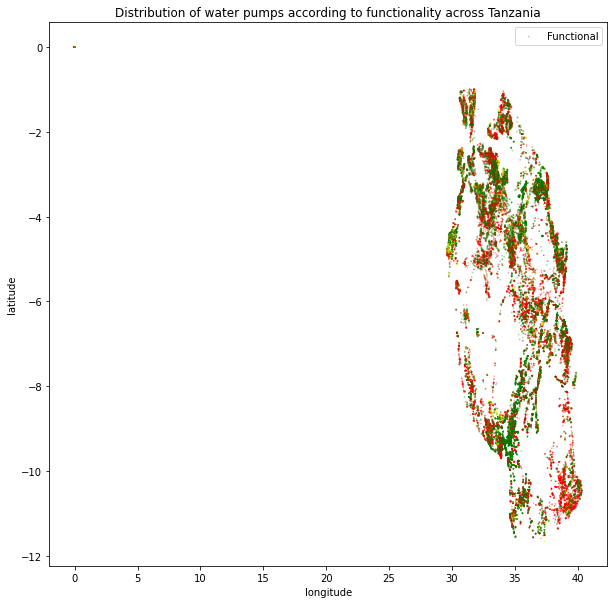

In [61]:
#Setting the s parameter to a slightly smaller value helps us to visualise the density of the distribution of water pumps across Tanzania

#Setting a colour to represent each status group
#Green means functional
#Yellow means functional but in need of repair
#Red means non functional
coordinates["colour"] = coordinates["status_group"]
coordinates["colour"] = coordinates["colour"].map(
    {"functional": "green",
     "functional needs repair": "yellow",
     "non functional": "red"}
)

print(coordinates.head())

coordinates.plot(x="longitude",
                  y="latitude",
                  kind="scatter",
                 title="Distribution of water pumps according to functionality across Tanzania",
                  alpha=0.3,
                 figsize=(10,10),
                  s=0.5,
                c = coordinates["colour"]
                  )

#plt.legend(['Functional', 'Needs Repair', 'Not Functional']);

We now have a very clear picture of the distribution of functional vs non functional water pumps across Tanzania.

From the visualisation we can see that there is a high density of pumps that are no longer function in the South Eastern & South Western region, some in the central region of the country and a few in the north. There also appear to be large areas where there are no pumps, perhaps these are mountainous regions where installing pumps would be difficult or of little benefit.

From this we can conclude that the longitude and latitude may be significant features to use, given that pumps of the same classification appear to be clustered together. However there will ofcourse likely be other features to consider besides the location.



# Data Preperation

In order to prepare our data before we can apply any machine learning model there are a number of areas to consider. The code snippet below represents the final outcome of much fine tuning.

### Imputation
There are a number of missing values in the population column.Missing values in this column are identified by a 0. We apply a transformer to the column that imputes the missing feature values using the median. This means that missing values are replaced with the median value of the feature distribution.

### Numerical Feature Scaling
There are 4 numerical features that we will be using to make predictions. These are listed in the num array below. The approach is to normalize the features, the objective of normalization here is to ensure that our features are comparable to one another.

Prior to scaling all 4 numerical features in our array are recorded using different units of measurement, we need to normalise these such that they can be compared to one another. Normalisation is also a good approach to adopt where we can assume that gaussian distribution does not exist amongst out features.

### Categorical Feature Encoding
There were two approaches to consider here.

The first was to "One hot encode" the categorical features i.e. transpose all possible values of the categorical feature into columns, populating each column with a 0 or 1, the end result would be a binary representation of whether or not our record was in possession of the given feature. However on testing this resulted in approx 44k features, given the high dimensionality and the risk of overfitting introduced i.e. Curse of Dimensionality it was decided to abandon this approach.

N.B, Any categorical features with more than 10 distinct values were removed. This was to prevent the dimensionality of our dataset from from expanding exponentially.

Instead each categorical feature to use for building the models is listed in the cat_attr array. For each we map the distinct aggregated values to a map of integers and replace the category value with the corresponding integer. I.e. instead of Red, Yellow, Green, Red our values would now read 1, 2, 3, 1. This also covers us for missing feature values as all missing values (NaN) would be assigned the same integer.

### Dropping Variables
A number of variables that were decided to not contain any meaningful data i.e. unique id or other features with significant amounts of 'garbage data' were removed.

In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#Transformation Pipelines

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

scaler = MinMaxScaler(feature_range=(0,1))

imputer = SimpleImputer(strategy="median", missing_values=0)
trainingData["population"] = imputer.fit_transform(trainingData[["population"]])

num = [
    "gps_height",
    "longitude",
    "latitude",
    "population"
]

num_normalise = []


for n in num:
    #trainingData[n] = scaler.fit_transform(trainingData[[n]])
    trainingData[n] = Normalizer().transform(trainingData[[n]].values)

# for n in num_normalise:
#     trainingData[n] = Normalizer().transform(trainingData[[n]])


cat_attr_to_scale = [
    "funder",
    "installer",
    "wpt_name",
    "basin",
    "subvillage",
    "region",
    "lga",
    "ward",
    "recorded_by",
    "scheme_management",
    "extraction_type",
    "extraction_type_group",
    "extraction_type_class",
    "management",
    "management_group",
    "water_quality",
    "quality_group",
    "quantity",
    "quantity_group",
    "source",
    "source_type",
    "source_class",
    "waterpoint_type",
    "waterpoint_type_group",
    "public_meeting",
    "payment",
    "amount_tsh"
]

#Removing categorical feature with large number of possible values to avoid overfitting
for cat in cat_attr_to_scale:
    # print(
    #     cat,trainingData[cat].nunique()
    # )
    if trainingData[cat].nunique() > 10:
        trainingData.drop(columns=cat,inplace=True)
        cat_attr_to_scale.remove(cat)

#Mapping remaining categorical values to integers to avoid adding additional features to our training data (else our training data set would have in excess of 4k features)
for remain in cat_attr_to_scale:
    #print(remain)
    trainingData[remain] = trainingData[remain].astype("category").cat.codes

#Final Cleanup
colToRemove = [
    "id",
    "date_recorded",
    #"payment",
    "payment_type",
    "permit",
    #"amount_tsh",
    "installer",
    "construction_year"
]

for c in colToRemove:
    trainingData = trainingData.drop(c, axis=1)


# Model Training

First we load our labels i.e. the desired prediction values.

The prediction labels are currently in string format, we map these to integers and store the integer classification value as a new column in the dataframe.

This newly added column is then stored as a series in the variable y_response. This represents the desired classification prediction for all records in our training data set.

In [46]:
test_data = pd.read_csv('trainingLabels.csv')
test_data["response"] = test_data["status_group"].map(
    {"functional": 1,
     "functional needs repair": 2,
     "non functional": 3}
)
test_data = test_data.sort_values("id")
y_response = test_data["response"]

## Decision Tree Classifier

The first model we will evaluate is a Decision Tree Classifier. We are using k-fold cross validation to train our model over k folds of the training data.

As we can see across the k folds we attain an average accuracy of 0.78. On first running the classifier our classification accuracy was 0.70, this was improved to its current level by including additional features and changes to the numerical scaling strategy.

Our model performs poorly when it comes to predicting a classification of class 2. From the looks of the confusion matrix below and given the nature of a decision tree we may assume that many features of pumps that are functional but require repair are similar to those that are functional without a need for repair.  

In [47]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


kfold = KFold(n_splits=10, random_state=7, shuffle=True)
dtc = DecisionTreeClassifier(
                             )
dtc.fit(trainingData, y_response)
results = cross_val_score(dtc, trainingData, y_response, cv=kfold)

print(
    "Average accuracy of Decision Tree Classifier" ,   round(results.mean(),2)
)

#Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(DecisionTreeClassifier(),
                                 trainingData,
                                 y_response,
                                 cv=kfold) #Y train pred is a vector of predictions made using our model

cm = confusion_matrix(y_response, y_train_pred)

print(cm)

Average accuracy of Decision Tree Classifier 0.78
[[28042   945  3272]
 [ 2261  1360   696]
 [ 5425   663 16736]]


## Schotastic Gradient Descent - Classification

Here we evaluate the effectiveness of an SGD Model.

Gradient descent is an optimization algorithm that aims to minimise the cost function in a given supervised machine learning problem. One such example would be using gradient descent to minimise the MSE (prediction error), ideally a data scientist would be gradient descent to minimise the cost function.

We do so by iteratively moving in the direction of the steepest descent, the steepest descent is defined here by the negative of the gradient. This model performs rather poorly, however we should simulate the model with different hyper-parameters using the CVGridSearch function.


In [56]:

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="log",
                        shuffle=True,
                        learning_rate='adaptive',
                        eta0=1,
                        early_stopping=True,
                        random_state=42)

sgd_clf.fit(trainingData, y_response)

acc_sgd = cross_val_score(sgd_clf, trainingData, y_response, cv=10)

y_train_pred_sgd = cross_val_predict(sgd_clf, trainingData, y_response, cv=kfold)
#Y train pred is a vector of predictions made using our model
cm = confusion_matrix(y_response, y_train_pred_sgd)

print("Average accuracy of SGD Classifier using a logistic loss function: ",round(acc_sgd.mean(),3))

print(cm)

Average accuracy of SGD Classifier using a logistic loss function:  0.576
[[22556   205  9498]
 [ 3114    21  1182]
 [10925   180 11719]]


## Random Forest Classifier

Here we explore optimal hyperparameters for a decision tree classifier using a random forest and grid search. Random forests are a very efficient statistical learning method.

They build on the idea of bagging, however they provide an improvement as they de-correlates the tree.

Random forests works by building a number of decision trees using bootstrapped training samples. However, when building these trees each time a split in a tree is considered a random sample of m predictors is chosen as split candidates from the full set of p predictors (m is usually the square root of the total number of predictors).

We do this so that at each split in the tree the random forest algorithm is not even allowed to consider a majority of the available predictors.
•	If there were a very strong predictor in our data set amongst many other strong predictors. Then tin the collection of bagged trees the majority of these would use the strong predictor in the top split, subsequently all of the bagged trees would look quite similar, hence any predictions made would be highly correlated.
•	Average quantities that are highly correlated does not lead to as large of a reduction in variance as average un-correlated values.

Random forests overcome this problem by forcing each split to consider only a subset of the predictors. Therefore an average (p-m)/p of the splits will not even consider the dominant predictor.

In addition to this we are building random forest models using the Grid Search CV function to explore a number of combinations of hyper-parameters.

Even with some hyperparameter tuning, the best accuracy our model can attain is 73%


In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [2, 3, 4, 5, 7,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= kfold)

CV_rfc.fit(
    trainingData,
    y_response
)

print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 10}
0.7308249158249158


# Feature Importance

We may wish to fine tune our model further, the code below creates a new data frame with each feature and its given importance in our Decision Tree Classifier. I have chosen this model as so far it is our best performing model.

To refine the model further we could remove unimportant features or even perform additional feature engineering. The code which has been commented our below covers removing any unimportant features below a fiven threshold.

In [64]:
dtc_feature_imp = dtc.feature_importances_
headers = trainingData.columns

imp = {
    "Feature": headers,
    "Importance": dtc_feature_imp
}

imp_df = pd.DataFrame(imp).sort_values("Importance", ascending=False)

imp_df

# trainingData_remove_unimp = trainingData.copy()
#
# for i in range(0, len(dtc_feature_imp)):
#     print(headers[i], dtc_feature_imp[i])
#     if dtc_feature_imp[i] < 0.025:
#         #print(dtc_feature_imp[i], headers[i])
#         trainingData_remove_unimp.drop(headers[i], axis=1, inplace=True)
#
# kfold = KFold(n_splits=10, random_state=7, shuffle=True)
# dtc_unimp = DecisionTreeClassifier(
# )
# dtc_unimp.fit(trainingData_remove_unimp, y_response)
# results = cross_val_score(dtc_unimp, trainingData_remove_unimp, y_response, cv=kfold)
#
# print(results.mean())

,Feature,Importance
19,quantity_group,0.208982
8,ward,0.188034
23,waterpoint_type,0.118671
7,district_code,0.062724
5,region,0.062311
15,payment,0.051566
13,extraction_type_class,0.041322
12,extraction_type,0.033559
4,basin,0.032839
6,region_code,0.032359
